In [4]:
import os, json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_DIR = r"../images/train"  # <-- change if needed
IMG_SIZE = (48, 48)
BATCH_SIZE = 64


In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="validation"
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)
print("Num classes:", num_classes)


Found 28821 files belonging to 7 classes.
Using 23057 files for training.
Found 28821 files belonging to 7 classes.
Using 5764 files for validation.
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Num classes: 7


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="validation"
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)
print("Num classes:", num_classes)


Found 28821 files belonging to 7 classes.
Using 23057 files for training.
Found 28821 files belonging to 7 classes.
Using 5764 files for validation.
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Num classes: 7


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

# Normalize to 0..1
normalizer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalizer(x), y)).cache().prefetch(AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (normalizer(x), y)).cache().prefetch(AUTOTUNE)


In [7]:
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.10),
], name="augment")

inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))

x = data_aug(inputs)
x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Dropout(0.20)(x)

x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Dropout(0.30)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.35)(x)

outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 augment (Sequential)        (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0    

In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-6),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25


361/361 [==============================] - 75s 197ms/step - loss: 1.8781 - accuracy: 0.2671 - val_loss: 2.7836 - val_accuracy: 0.2332 - lr: 0.0010
Epoch 2/25
361/361 [==============================] - 29s 81ms/step - loss: 1.6732 - accuracy: 0.3309 - val_loss: 1.5544 - val_accuracy: 0.3884 - lr: 0.0010
Epoch 3/25
361/361 [==============================] - 30s 83ms/step - loss: 1.6030 - accuracy: 0.3631 - val_loss: 1.4586 - val_accuracy: 0.4237 - lr: 0.0010
Epoch 4/25
361/361 [==============================] - 33s 91ms/step - loss: 1.5598 - accuracy: 0.3843 - val_loss: 1.4641 - val_accuracy: 0.4344 - lr: 0.0010
Epoch 5/25
361/361 [==============================] - 33s 93ms/step - loss: 1.5222 - accuracy: 0.4047 - val_loss: 1.3814 - val_accuracy: 0.4681 - lr: 0.0010
Epoch 6/25
361/361 [==============================] - 35s 96ms/step - loss: 1.4912 - accuracy: 0.4200 - val_loss: 1.3928 - val_accuracy: 0.4549 - lr: 0.0010
Epoch 7/25
361/361 [==============================] - 3

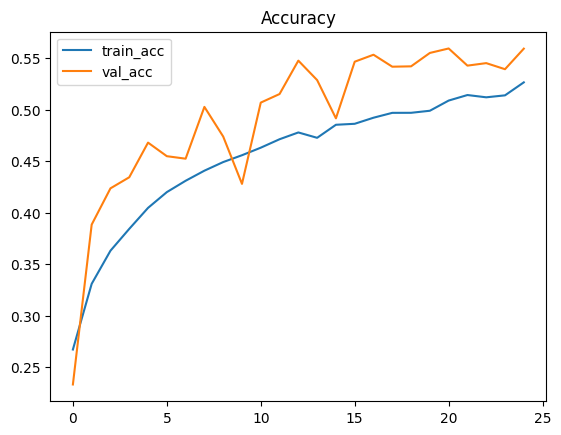

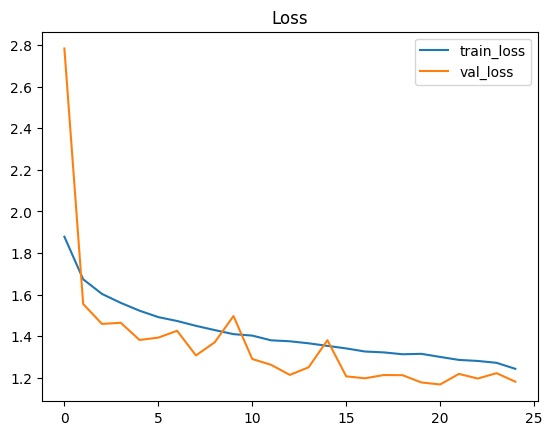

In [11]:
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()


In [12]:
os.makedirs("../backend", exist_ok=True)

model.save("../backend/emotion_model.keras")  # best format
with open("../backend/class_names.json", "w") as f:
    json.dump(class_names, f)

print("✅ Saved: backend/emotion_model.keras")
print("✅ Saved: backend/class_names.json")



✅ Saved: backend/emotion_model.keras
✅ Saved: backend/class_names.json


In [ ]:
model=tf,karas.models.Sequential{[
    tf.karas.layers.Con2D{10,(5,5),activation='relu', input_shape(64,64,3),
    tf.karas.layers.MaxPooling2D((3,3),stride=(3,3)

    tf.karas.layers.Con2D{16,(5,5),activation='relu',
    tf.karas.layers.MaxPooling2D((3,3),stride=(3,3)
                             
